  # SENTIMENTAL ANALYSIS USING TWEETS


> ## Text Classification using LSTM


---

> This is the twitter dataset. It contains 1,600,000 tweets and Contains Six Columns 'target', 'ids', 'date', 'flag', 'user', 'text'.The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.








In [ ]:
# !pip install --upgrade nltk
# !pip install tensorflow==2.15

In [ ]:
import tensorflow as tf
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional


import numpy as np
import pandas as pd


import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re






from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [ ]:
column_names = ["target", "id", "date", "flag", "user", "text"]

data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=column_names)
# test_tweets  = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv',names=['id', 'User', 'target','text'])


In [ ]:
train_tweets= data.copy()
train_tweets.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_tweets["target"].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
train_tweets=train_tweets[["target","text"]]

# ***Data pre-processing***

### This code cell performs data preprocessing on the train_tweets DataFrame:



1.   It prints the shape of the DataFrame.
2.   It prints the count of null values in each column of the DataFrame
3.   It drops rows with null values from the DataFrame if there is one.
4.   It prints the shape of the DataFrame after dropping null values.


In [ ]:
print("shape of train_data:" ,train_tweets.shape)
print("count the nul value:" ,train_tweets.isnull().sum())

train_tweets.head(5)

shape of train_data: (1600000, 2)
count the nul value: target    0
text      0
dtype: int64


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."



# *Data Preprocessing and Label Refinement for Sentiment Analysis*
1. Filtering Rows: The first line filters rows in the DataFrame where the value in the 'target' column is equal to 4. It uses boolean indexing with .loc[] to select rows meeting this condition. Then, it assigns the value 1 to the 'target' column for these selected rows

3. Counting Values: The second line calculates the count of unique values in the 'target' column of the DataFrame using the value_counts() method. This method returns a Series with the counts of unique values in descending order.

In [ ]:
train_tweets.loc[train_tweets['target'] == 4, 'target'] = 1
train_tweets["target"].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
train_tweets = train_tweets.rename(columns={'target': 'label'})


m_train = train_tweets.copy()
m_train.reset_index(inplace=True)

In [ ]:
#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# pd.options.plotting.backend = "plotly"

<Axes: xlabel='label'>

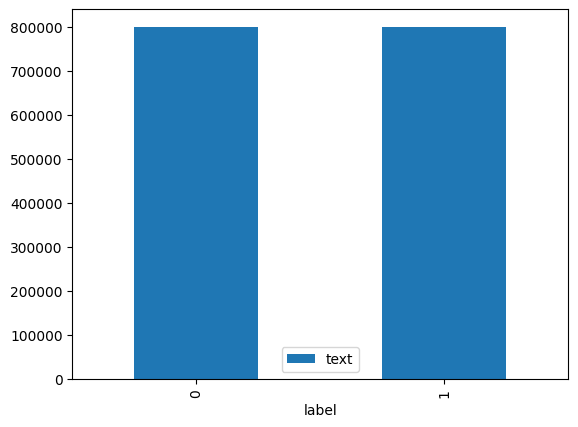

In [ ]:

data_train = m_train[['text', 'label']].copy()
data_train.groupby('label').count().plot(kind='bar')

*This code snippet uses NLTK and regular expressions to preprocess text data. It removes non-alphabetic characters, converts text to lowercase, and applies stemming (`Lemmentization`)while excluding stopwords. The resulting preprocessed text is stored in a list called `corpus`, facilitating further analysis such as sentiment analysis or topic modeling.*

---



In [ ]:
import string

def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    # links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # multiple dots
    text = re.sub('<.*?>+', '', text)
    # punctuation
    text = re.sub('[%s]' % re.escape(str.punctuation), '', text)
    # new lines
    text = re.sub('\n', '', text)
    # words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Remove any remaining non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)
    return text

In [ ]:
from keras.preprocessing.text import Tokenizer

# Download NLTK resources

# nltk.download()
nltk.download('stopwords')
nltk.download('wordnet')

# nltk.data.path.append('/kaggle/working/')


class TextPreprocessor:
    def __init__(self):
        # Initialize lemmatizer and stemmer
        self.lemm = WordNetLemmatizer()
        self.stemmer = PorterStemmer()

        # Define stopwords including negation words
        self.stop_words = set(stopwords.words('english'))
        self.negation_words = {'not', 'no', 'never', 'nor','neither', 'none', 'nobody', 'nothing', 'nowhere','cannot', "couldn't", "shouldn't", "wouldn't", "won't"}
        self.stop_words -= self.negation_words

        # Initialize corpus
        self.corpus = []

    def normalized_text(self, data):
        """Preprocesses text data."""
        for i in range(len(data)):
#             review =  clean_text(data[i])
            review = re.sub('[^a-zA-Z]', ' ', data[i])
            review = review.lower()
            review = review.split()
            review = [self.lemm.lemmatize(word) for word in review if word not in self.stop_words]
            review = ' '.join(review)
            self.corpus.append(review)
        return self.corpus

    def preprocess_text(self, df, voc_size, sent_length):

      onehot_repr = [one_hot(words, voc_size) for words in df]
      embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
      return embedded_docs

    def vectorized_text(self,num_words,df,sent_length):
        tok = Tokenizer(num_words)
        tok.fit_on_texts(df)
        sequences = tok.texts_to_sequences(df)
        sequences_matrix = pad_sequences(sequences,maxlen=max_length)

        return sequences_matrix





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# pip install --upgrade nltk


In [ ]:
import nltk


train_data_preprocessor = TextPreprocessor()

df2 = train_data_preprocessor.normalized_text(data_train['text'])

print( pd.DataFrame({'text': df2}).shape)


(1600000, 1)


In [ ]:
print( pd.DataFrame({'text': df2}))

                                                      text
0        switchfoot http twitpic com zl awww bummer sho...
1        upset update facebook texting might cry result...
2        kenichan dived many time ball managed save res...
3                          whole body feel itchy like fire
4                  nationwideclass no not behaving mad see
...                                                    ...
1599995                   woke no school best feeling ever
1599996  thewdb com cool hear old walt interview http b...
1599997                     ready mojo makeover ask detail
1599998  happy th birthday boo alll time tupac amaru sh...
1599999  happy charitytuesday thenspcc sparkscharity sp...

[1600000 rows x 1 columns]


In [ ]:
max_length = 0

# Iterate through each string in the list
for string in df2:

    words = string.split()

    for word in words:
        # Update maximum length if necessary
        max_length = max(max_length, len(word))


print("Maximum length of a word:", max_length)

Maximum length of a word: 117


In [ ]:

# max_len = 500
# tok = Tokenizer(num_words=2000)
# tok.fit_on_texts(df2)
# sequences = tok.texts_to_sequences(df2)
# sequences_matrix = pad_sequences(sequences,maxlen=max_length)



In [ ]:


voc_size=2000

embedded_docs_train =train_data_preprocessor.vectorized_text(voc_size,df2,max_length)
# sequences_matrix

In [ ]:

# voc_size=5000

# embedded_docs_train =train_data_preprocessor.preprocess_text(df2,voc_size,max_length)

# print(embedded_docs_train)

*This code block defines a neural network model for text classification. It utilizes an embedding layer to transform input words into dense vectors, followed by  LSTM layer to capture contextual information . The model is then compiled with the sparse categorical cross-entropy loss function, the RMSprop optimizer, and accuracy as the evaluation metric. Finally, the model summary is printed, providing an overview of its architecture and the number of trainable parameters.*

---



In [ ]:
# from keras.layers import Flatten
from keras.layers import Dropout as dropout

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score


# y_pred3.history

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
## Creating model
    embedding_vector_features=100
    model=Sequential()
    model.add(Embedding(voc_size,embedding_vector_features,input_length = max_length))

#     model.add(Embedding(voc_size,embedding_vector_features,input_shape=(max_length,)))

    # model.add(Bidirectional(LSTM(200,dropout=0.2,return_sequences=False)))

#     model.add(Flatten())

    model.add(Bidirectional(LSTM(units=256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.2)))

    model.add(Dense(64, activation='relu'))
    model.add(dropout(0.5))



    model.add(Dense(1,activation='sigmoid'))

    # Define EarlyStopping callback
#     early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'], jit_compile='False')
    print(model.summary())

In [ ]:
x_train=embedded_docs_train
y_train=data_train["label"]

x_train.shape,y_train.shape

((1600000, 117), (1600000,))

In [ ]:
embedded_docs_train.shape

(1600000, 117)

In [ ]:
# y_train = y_train.reshape((-1, 1))

In [ ]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: label, Length: 1600000, dtype: int64

In [ ]:
y_train.dtype

dtype('int64')

In [ ]:
x_train.dtype

dtype('int32')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size= 0.3 , random_state=64)

In [ ]:
y_pred3 = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=10,batch_size=100 )

Epoch 1/10


2024-04-10 18:47:58.495569: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.517488: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.539229: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.561707: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.583995: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.606100: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:47:58.627031: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

    3/11200 [..............................] - ETA: 8:19 - loss: 0.6622 - accuracy: 0.5288    

2024-04-10 18:48:14.136327: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.136607: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.136818: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.143500: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.145169: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.145505: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-10 18:48:14.145878: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

11200/11200 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.7301

2024-04-10 18:55:59.605091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


11200/11200 [==============================] - 543s 47ms/step - loss: 0.4778 - accuracy: 0.7301 - val_loss: 0.4535 - val_accuracy: 0.7435
Epoch 2/10
11200/11200 [==============================] - 537s 48ms/step - loss: 0.4572 - accuracy: 0.7446 - val_loss: 0.4479 - val_accuracy: 0.7479
Epoch 3/10
11200/11200 [==============================] - 534s 48ms/step - loss: 0.4519 - accuracy: 0.7473 - val_loss: 0.4456 - val_accuracy: 0.7493
Epoch 4/10
11200/11200 [==============================] - 534s 48ms/step - loss: 0.4495 - accuracy: 0.7488 - val_loss: 0.4440 - val_accuracy: 0.7498
Epoch 5/10
11200/11200 [==============================] - 524s 47ms/step - loss: 0.4480 - accuracy: 0.7498 - val_loss: 0.4421 - val_accuracy: 0.7507
Epoch 6/10
11200/11200 [==============================] - 522s 47ms/step - loss: 0.4478 - accuracy: 0.7502 - val_loss: 0.4445 - val_accuracy: 0.7508
Epoch 7/10
11200/11200 [==============================] - 530s 47ms/step - loss: 0.4479 - accuracy: 0.7505 - val_loss

In [ ]:
y_predict = model.predict(X_test)
y_predict

2024-04-10 20:16:35.159055: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


15000/15000 [==============================] - 166s 11ms/step


array([[0.9115588 ],
       [0.9044721 ],
       [0.31153518],
       ...,
       [0.03039557],
       [0.9236398 ],
       [0.15371886]], dtype=float32)

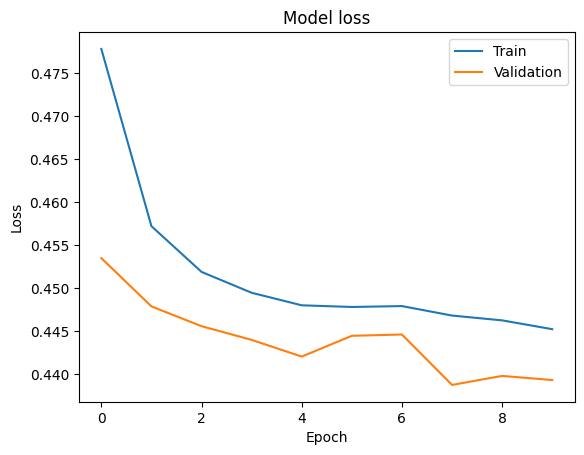

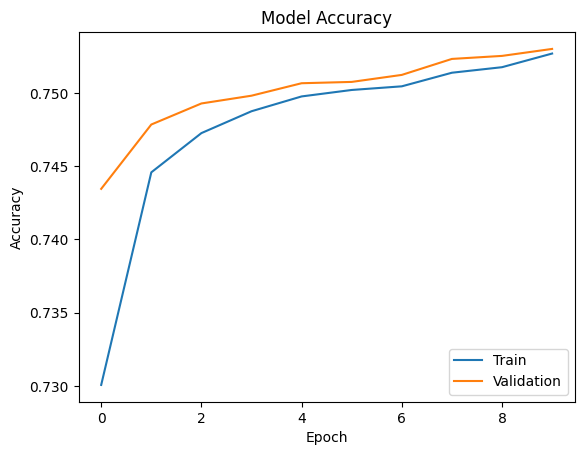

In [ ]:
plt.plot(y_pred3.history['loss'])
plt.plot(y_pred3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Plot the accuracy of training and validation
plt.plot(y_pred3.history['accuracy'])
plt.plot(y_pred3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# model.save('sentimentalAnalysisTweets.h5')
